In [1]:
!pip install MulensModel
!pip install emcee
!pip install corner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.7/20.7 MB 64.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for MulensModel: filename=mulensmodel-3.3.1-cp312-cp312-linux_x86_64.whl size=10909235 sha256=2672d77bfbd5f6556a9ac9a19abdeb948c65f78889c4d740350807c519c0baa4
  Stored in directory: /root/.cache/pip/wheels/fa/83/d3/97f305270a6d3574634e5fd1b9571aea54175e386db454558e
Successfully built MulensModel
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 2.3 MB/s eta 0:00:00


In [ ]:
"""
Script for simulating microlensing lightcurves.
All settings are controlled from a yaml file. Example input:

    python example_18_simulate.py example_18_input_1.yaml

    python example_18_simulate.py example_18_input_2.yaml

The first one is very simple. The second one is more complicated.
"""
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import sys
import yaml

import MulensModel as mm

# Fix values of: s, q, and t_E (Separation, mass ratio and einstein crossing time )

# s: separation between the two lensing bodies in EINSTEIN RADIUS UNITS.
# q: ratio of the masses of two lens bodies.
# t_E: time it takes to the source to cross a distance equals to einsteins ring to the lens.


def simulate_lc(
        parameters, time_settings, file_out,
        coords=None, methods=None,
        flux_source=1000., flux_blending=0.,
        relative_uncertainty=0.01,
        plot=True, subtract_2450000=True):
    """
    Simulate and save light curve.

    Parameters :
        parameters: *dict*
            Parameters of the model - keys are in MulensModel format, e.g.,
            't_0', 'u_0', 't_E' etc.

        time_settings: *dict*
            Sets properties of time vector. It requires key `type`, which can
            have one of two values:
            - `random` (requires `n_epochs`, `t_start`, and `t_stop`) or
            - `evenly spaced` (settings passed to `Model.set_times()`).

        file_out: *str*
            Name of the file to be saved.

        coords: *str*
            Event coordinates for parallax calculations, e.g.,
            "17:34:51.15 -30:29:28.27".

        methods: *list*
            Define methods used to calculate magnification. The format is
            the same as MulensModel.Model.set_magnification_methods().

        flux_source: *float*
            Flux of source.

        flux_blending: *float*
            Blending flux.

        relative_uncertainty: *float*
            Relative uncertainty of the simulated data (this is close to
            sigma in magnitudes).

        plot: *bool*
            Plot the data and model at the end?

        subtract_2450000: *bool*
            Do you want shorter JD values?
    """
    model = mm.Model(parameters, coords=coords)

    if time_settings['type'] == 'random':
        raw = np.random.rand(time_settings['n_epochs'])
        dt = time_settings['t_stop'] - time_settings['t_start']
        times = time_settings['t_start'] + np.sort(raw) * dt
    elif time_settings['type'] == 'evenly spaced':
        times = model.set_times(**time_settings)
    else:
        raise ValueError("unrecognized time_settings['type']: " +
                         time_settings['type'])

    if methods is not None:
        model.set_magnification_methods(methods)

    magnification = model.get_magnification(times)

    flux = flux_source * magnification + flux_blending
    flux_err = relative_uncertainty * flux

    flux *= 1 + relative_uncertainty * np.random.randn(len(flux))

    data = mm.MulensData([times, flux, flux_err], phot_fmt='flux')
    event = mm.Event([data], model)
    print("chi^2: {:.2f}".format(event.get_chi2()))

    if subtract_2450000:
        subtract = 2450000.
    else:
        subtract = 0.

    np.savetxt(file_out,
               np.array([times-subtract, data.mag, data.err_mag]).T,
               fmt='%.4f')

    if plot:
        model.plot_lc(subtract_2450000=subtract_2450000,
                      t_start=np.min(times), t_stop=np.max(times),
                      source_flux=flux_source, blend_flux=flux_blending)
        data.plot(phot_fmt='mag', subtract_2450000=subtract_2450000)
        plt.xticks(np.linspace(6000,6300, 11))
        minorticks = AutoMinorLocator(10)
        plt.gca().xaxis.set_minor_locator(minorticks)
        plt.grid(which='both', linestyle='-', linewidth='0.5', color='gray')
        plt.show()

"""
High-level fitting and plotting example with MulensModel.

Requires in-line argument whic|h is a config file, e.g.,
example_15_mb07192_v1.cfg or example_15_ob05390_v1.cfg.
"""

import emcee
import configparser


def ln_like(theta, event, parameters_to_fit, print_models):
    """
    Likelihood function. The values of *parameters_to_fit* are in *theta*.
    MulensModel Event class instance *event* gives event for which
    calculations will be done. Boolean *print_models* controls if
    all models are printed.
    """
    for (theta_, param) in zip(theta, parameters_to_fit):
        setattr(event.model.parameters, param, theta_)
    chi2 = event.get_chi2()
    if print_models:
        print(chi2, *[t for t in theta], flush=True)
    return -0.5 * chi2


def ln_prior(theta, parameters_to_fit):
    """
    Prior. Check if *theta* values for *parameters_to_fit* are within ranges
    defined by *ln_prior.min* and *ln_prior.max*.
    """
    inside = 0.
    outside = -np.inf

    for (parameter, value) in ln_prior.min.items():
        index = parameters_to_fit.index(parameter)
        if theta[index] < value:
            return outside

    for (parameter, value) in ln_prior.max.items():
        index = parameters_to_fit.index(parameter)
        if theta[index] > value:
            return outside

    return inside


def ln_prob(
        theta, event, parameters_to_fit, print_models=False):
    """
    Log probability of the model - combines ln_prior() and ln_like().
    """
    ln_prior_ = ln_prior(theta, parameters_to_fit)
    if not np.isfinite(ln_prior_):
        return -np.inf

    ln_like_ = ln_like(theta, event, parameters_to_fit, print_models)
    if np.isnan(ln_like_):
        return -np.inf


    return ln_prior_ + ln_like_


def generate_random_parameters(parameters, starting, n):
    """
    Generate *n* vectors of values of *parameters* according to distributions
    specified in *starting*.
    """
    values = []
    for param in parameters:
        settings = starting[param]
        if settings[0] == 'gauss':
            v = settings[2] * np.random.randn(n)
            v += settings[1]
        elif settings[0] == 'uniform':
            v = np.random.uniform(
                low=settings[1], high=settings[2], size=n)
        elif settings[0] == 'log-uniform':
            beg = np.log(settings[1])
            end = np.log(settings[2])
            v = np.exp(np.random.uniform(beg, end, n))
        else:
            raise ValueError('Unrecognized keyword: ' + settings[0])
        values.append(v)
    return np.array(values).T.tolist()

# PLAYGROUND
def vary_yaml_parameters(input_file, output_file, new_s, new_q, new_alpha, new_u0, new_tE):
    try:
        with open(input_file, 'r') as file:
            data = yaml.unsafe_load(file) # Still need unsafe_load for the original file

        # Access and modify the values, ensuring they are cast to standard floats
        data['parameters']['s'] = float(new_s)
        data['parameters']['q'] = float(new_q)
        data['parameters']['alpha'] = float(new_alpha)
        data['parameters']['u_0'] = float(new_u0)
        data['parameters']['t_E'] = float(new_tE)

        data['file_out'] = f'kmtnet_s_{new_s}_q_{new_q}_u0_{new_u0}.dat'

        # Dump the new data. yaml.dump() will now write standard floats.
        with open(output_file, 'w') as file:
            yaml.dump(data, file, sort_keys=False)

        print(f"Successfully updated parameters. New config saved to {output_file}")

    except FileNotFoundError:
        print(f"Error: The file '{input_file}' was not found.")
    except KeyError as e:
        print(f"Error: Parameter {e} not found in the YAML file.")


chi^2: 804.48


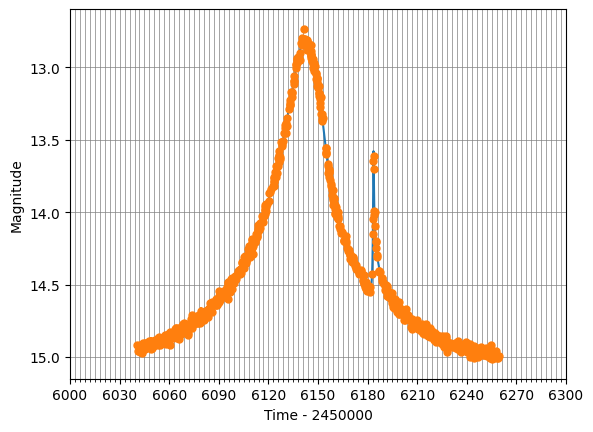

In [ ]:
# PLAYGROUND
if __name__ == '__main__':
    input_file = '/content/example_18_KMTNet.yaml'
    with open(input_file, 'r') as in_file:
        settings = yaml.safe_load(in_file)

    simulate_lc(**settings)

180.0
Successfully updated parameters. New config saved to /content/example_18_KMTNet.yaml
chi^2: 904.41


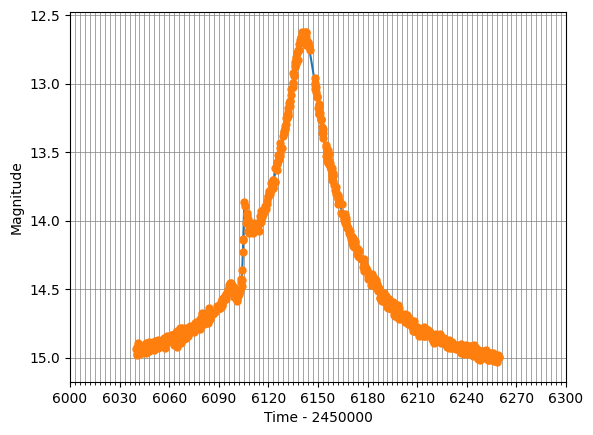

181.8181818181818
Successfully updated parameters. New config saved to /content/example_18_KMTNet.yaml
chi^2: 830.79


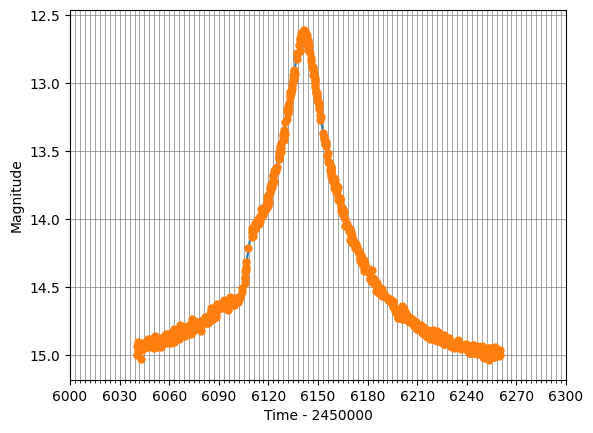

183.63636363636363
Successfully updated parameters. New config saved to /content/example_18_KMTNet.yaml
chi^2: 856.67


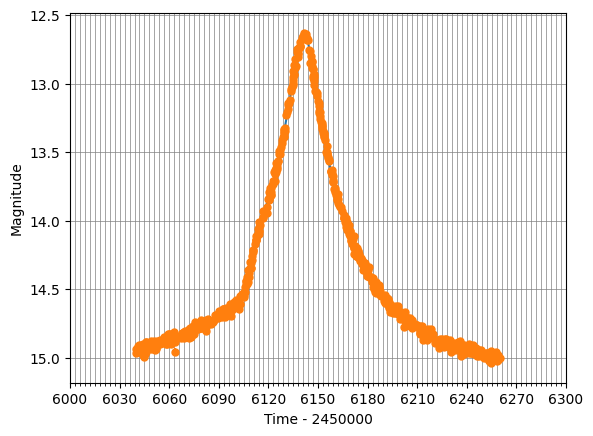

185.45454545454547
Successfully updated parameters. New config saved to /content/example_18_KMTNet.yaml
chi^2: 747.85


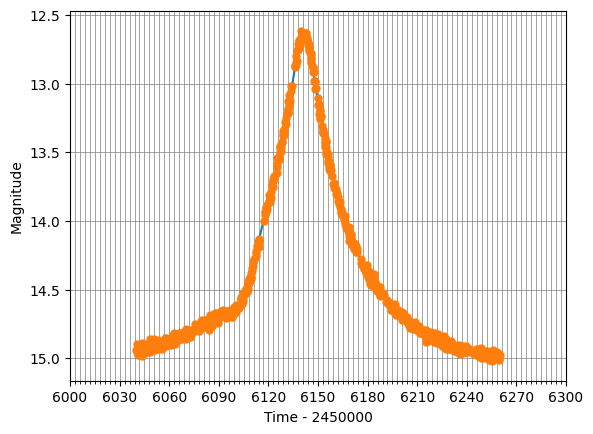

187.27272727272728
Successfully updated parameters. New config saved to /content/example_18_KMTNet.yaml
chi^2: 795.95


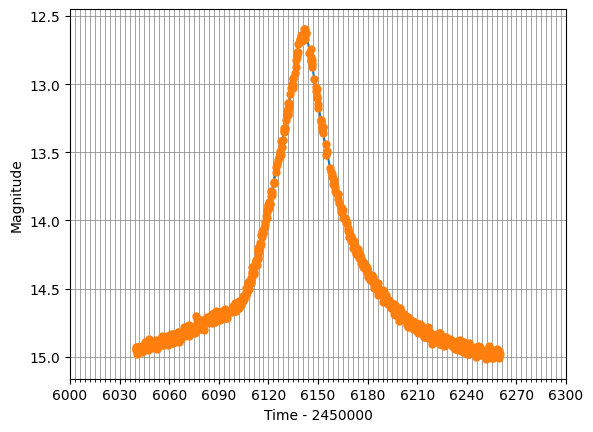

189.0909090909091
Successfully updated parameters. New config saved to /content/example_18_KMTNet.yaml
chi^2: 819.10


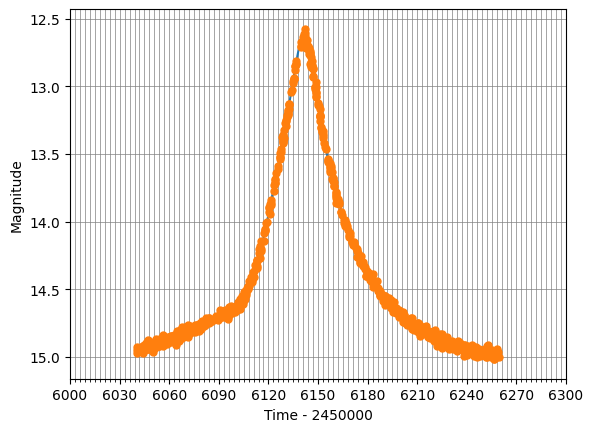

190.9090909090909
Successfully updated parameters. New config saved to /content/example_18_KMTNet.yaml
chi^2: 837.16


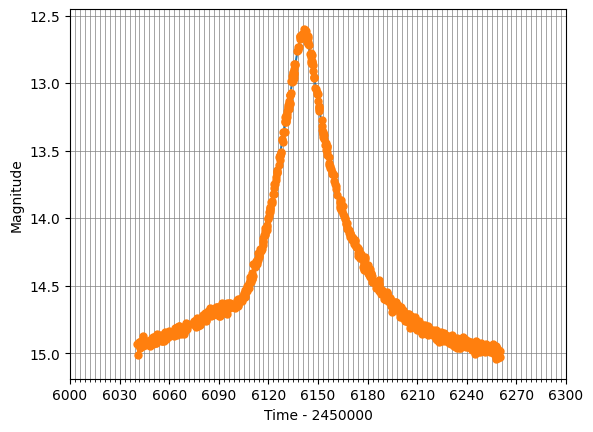

192.72727272727272
Successfully updated parameters. New config saved to /content/example_18_KMTNet.yaml
chi^2: 759.40


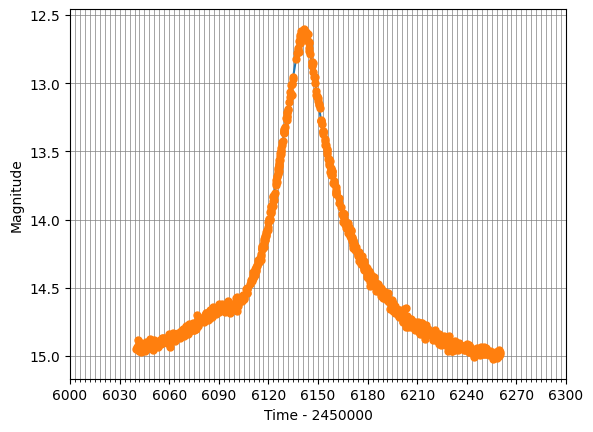

194.54545454545453
Successfully updated parameters. New config saved to /content/example_18_KMTNet.yaml
chi^2: 759.12


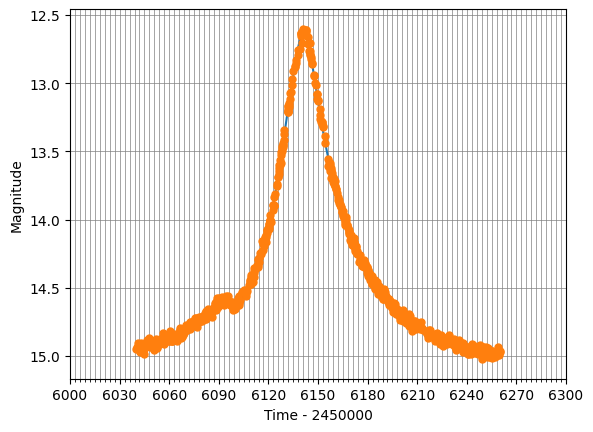

196.36363636363637
Successfully updated parameters. New config saved to /content/example_18_KMTNet.yaml
chi^2: 823.60


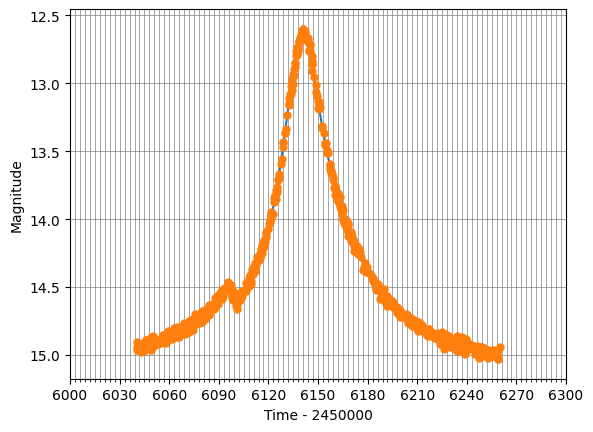

198.1818181818182
Successfully updated parameters. New config saved to /content/example_18_KMTNet.yaml
chi^2: 870.17


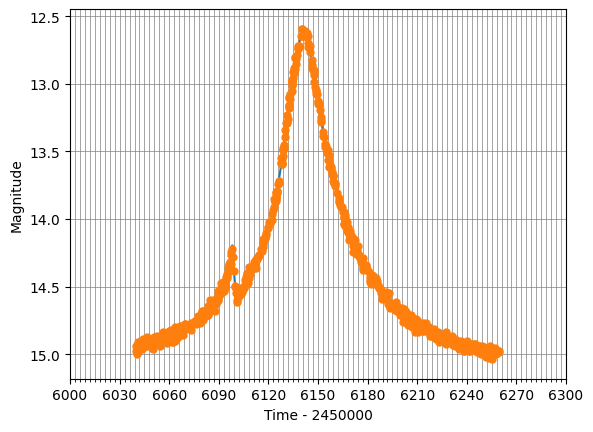

200.0
Successfully updated parameters. New config saved to /content/example_18_KMTNet.yaml
chi^2: 839.78


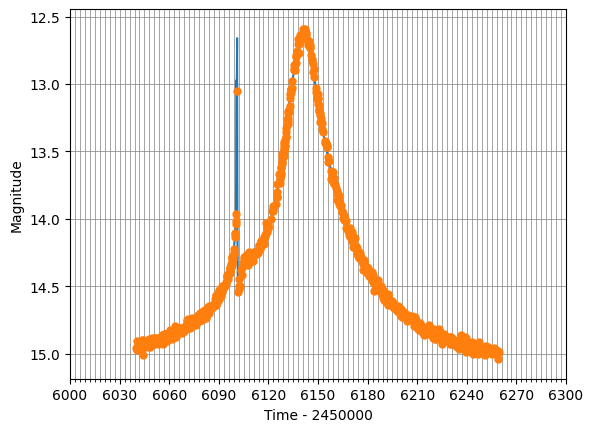

201.8181818181818
Successfully updated parameters. New config saved to /content/example_18_KMTNet.yaml
chi^2: 810.02


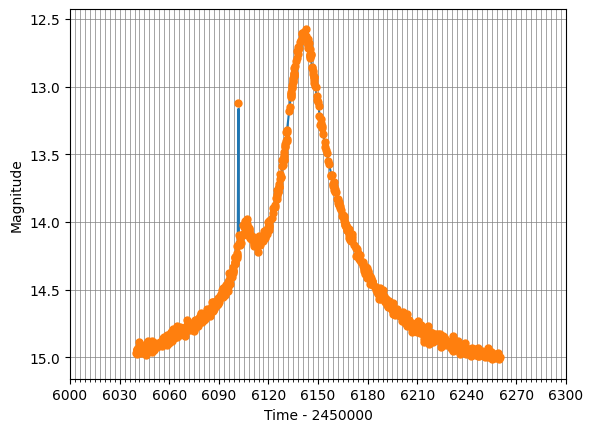

203.63636363636363
Successfully updated parameters. New config saved to /content/example_18_KMTNet.yaml
chi^2: 774.36


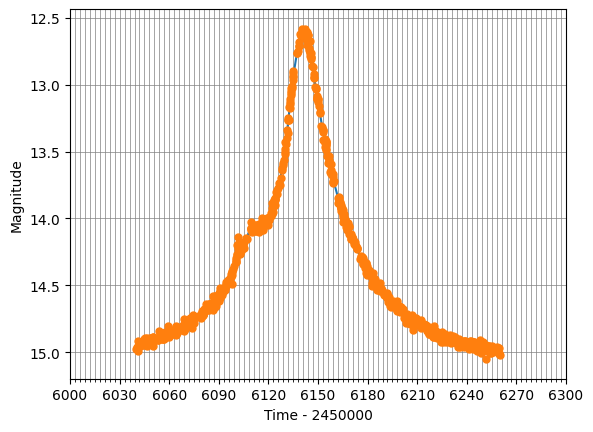

205.45454545454544
Successfully updated parameters. New config saved to /content/example_18_KMTNet.yaml
chi^2: 851.08


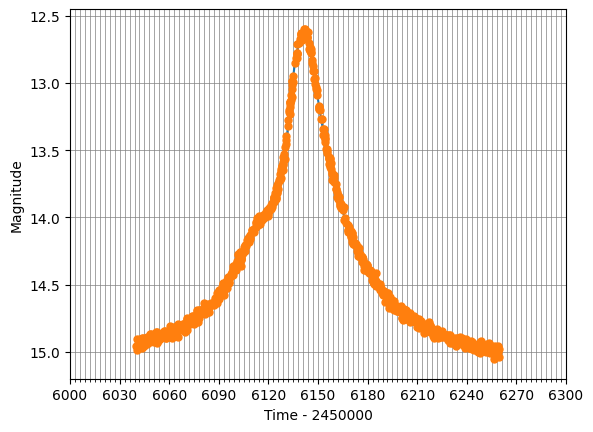

207.27272727272728
Successfully updated parameters. New config saved to /content/example_18_KMTNet.yaml
chi^2: 788.29


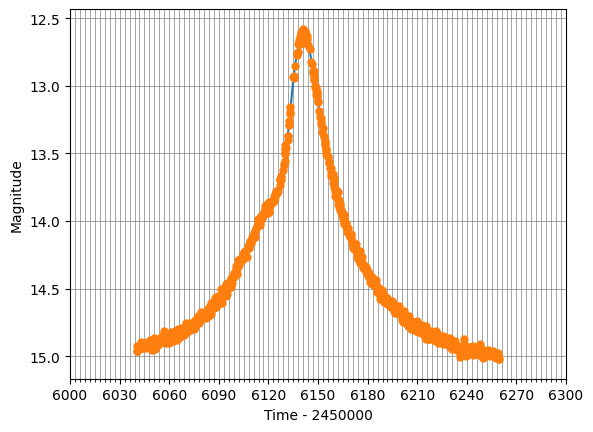

209.0909090909091
Successfully updated parameters. New config saved to /content/example_18_KMTNet.yaml
chi^2: 763.51


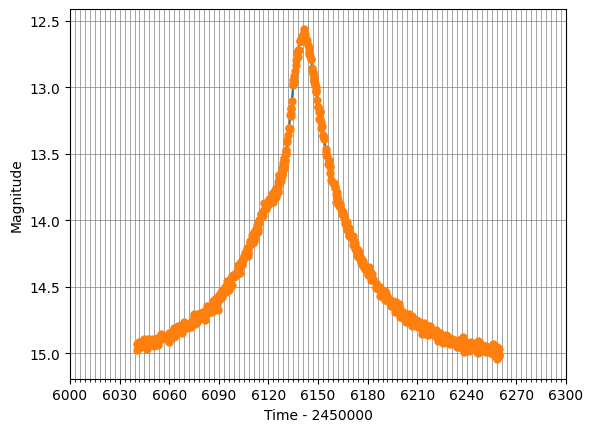

210.9090909090909
Successfully updated parameters. New config saved to /content/example_18_KMTNet.yaml
chi^2: 864.59


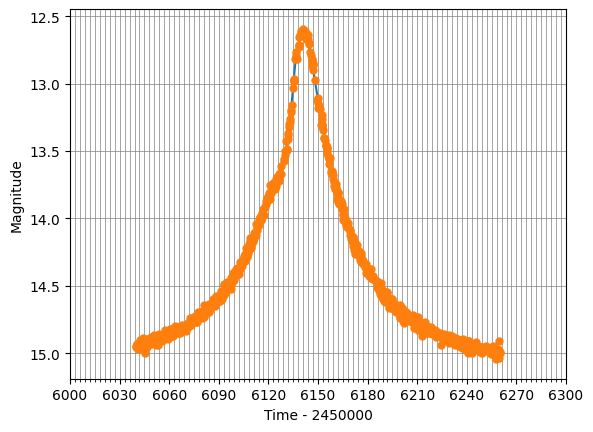

212.72727272727272
Successfully updated parameters. New config saved to /content/example_18_KMTNet.yaml
chi^2: 865.62


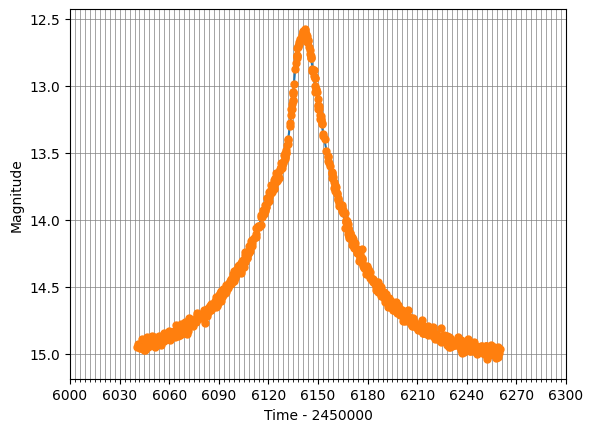

214.54545454545456
Successfully updated parameters. New config saved to /content/example_18_KMTNet.yaml
chi^2: 852.81


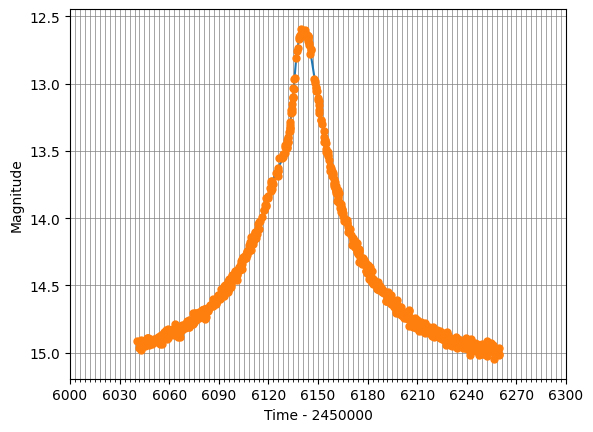

216.36363636363637
Successfully updated parameters. New config saved to /content/example_18_KMTNet.yaml
chi^2: 817.48


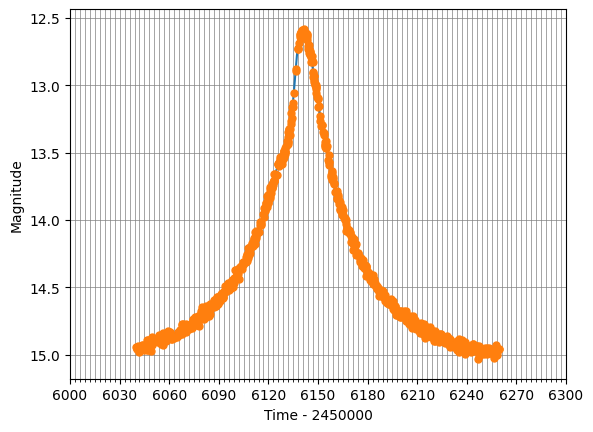

218.1818181818182
Successfully updated parameters. New config saved to /content/example_18_KMTNet.yaml
chi^2: 809.47


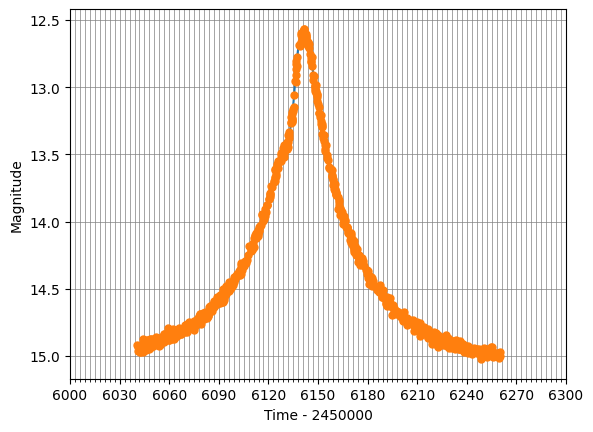

220.0
Successfully updated parameters. New config saved to /content/example_18_KMTNet.yaml
chi^2: 721.03


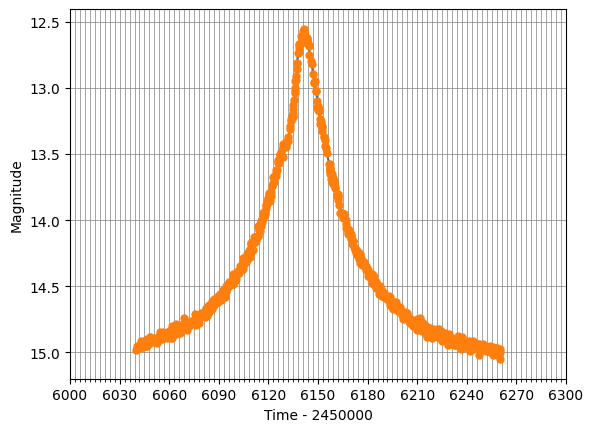

221.8181818181818
Successfully updated parameters. New config saved to /content/example_18_KMTNet.yaml
chi^2: 857.10


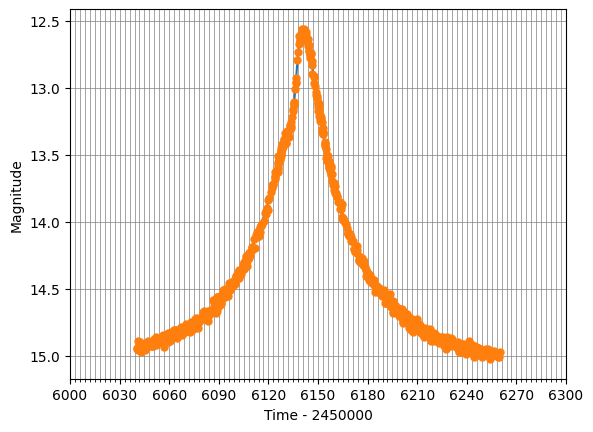

223.63636363636363
Successfully updated parameters. New config saved to /content/example_18_KMTNet.yaml
chi^2: 838.53


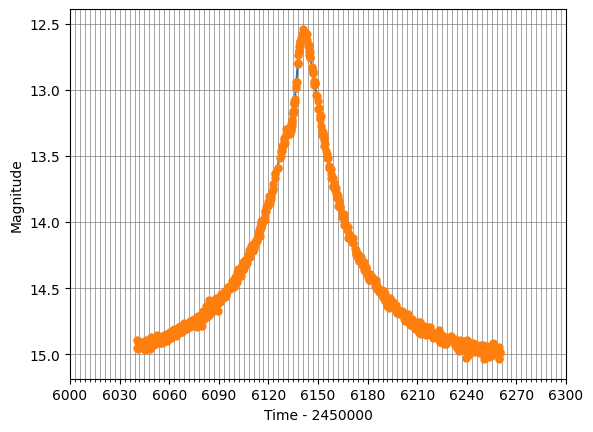

225.45454545454544
Successfully updated parameters. New config saved to /content/example_18_KMTNet.yaml
chi^2: 783.06


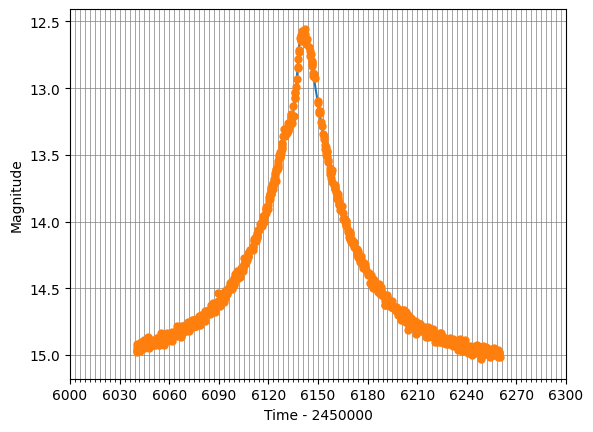

227.27272727272728
Successfully updated parameters. New config saved to /content/example_18_KMTNet.yaml
chi^2: 814.99


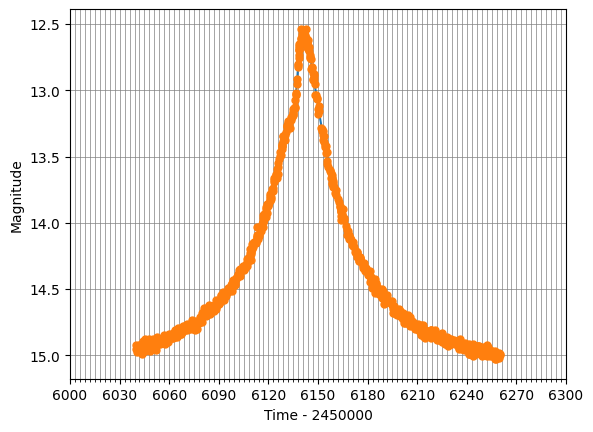

229.0909090909091
Successfully updated parameters. New config saved to /content/example_18_KMTNet.yaml
chi^2: 760.20


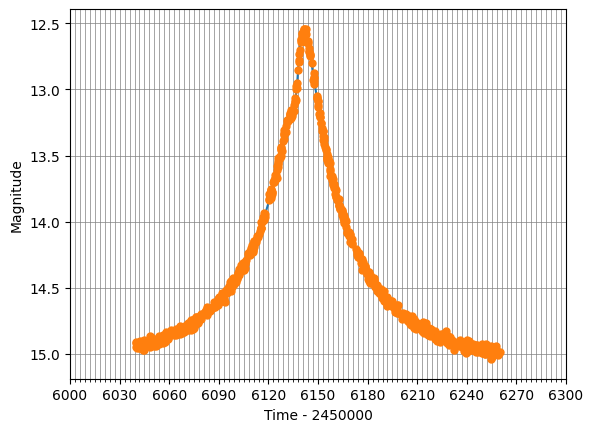

230.9090909090909
Successfully updated parameters. New config saved to /content/example_18_KMTNet.yaml
chi^2: 803.90


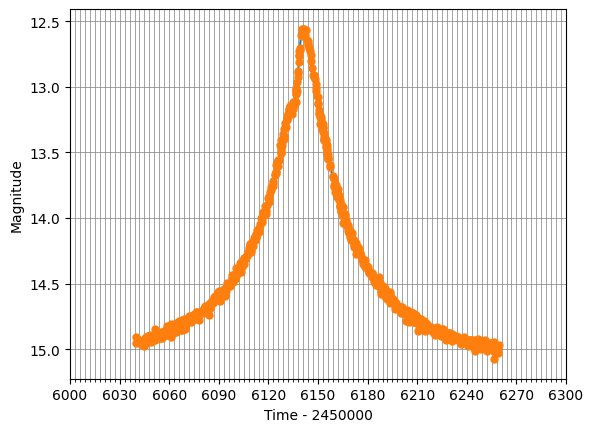

232.72727272727272
Successfully updated parameters. New config saved to /content/example_18_KMTNet.yaml
chi^2: 703.00


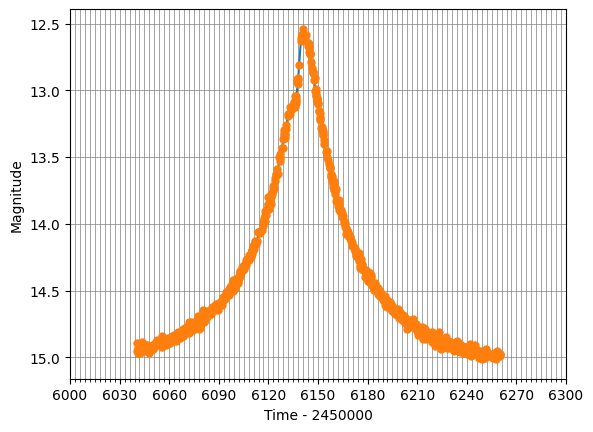

234.54545454545456
Successfully updated parameters. New config saved to /content/example_18_KMTNet.yaml
chi^2: 739.36


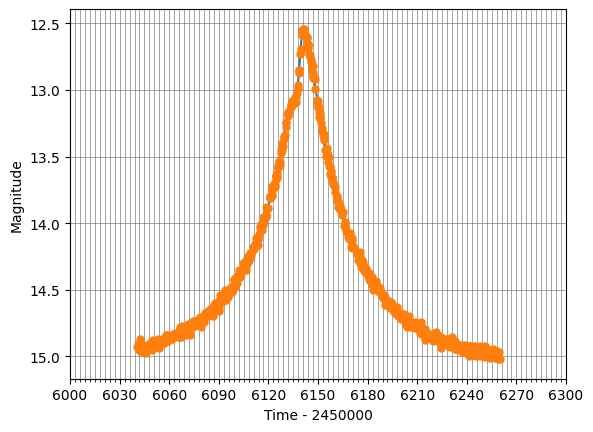

236.36363636363637
Successfully updated parameters. New config saved to /content/example_18_KMTNet.yaml
chi^2: 769.95


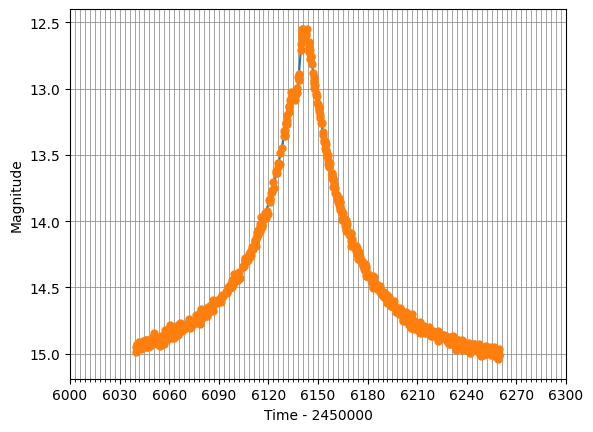

238.1818181818182
Successfully updated parameters. New config saved to /content/example_18_KMTNet.yaml
chi^2: 849.12


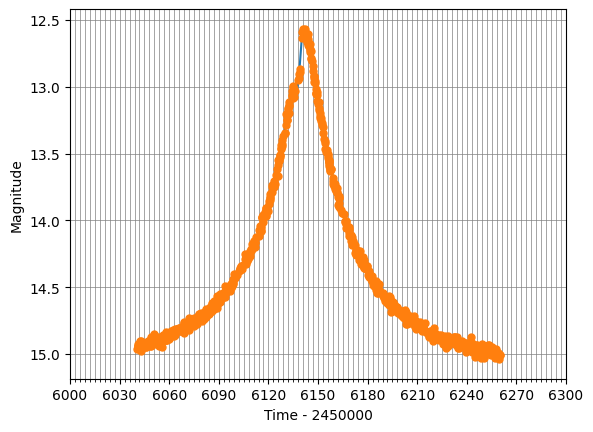

240.0
Successfully updated parameters. New config saved to /content/example_18_KMTNet.yaml
chi^2: 763.48


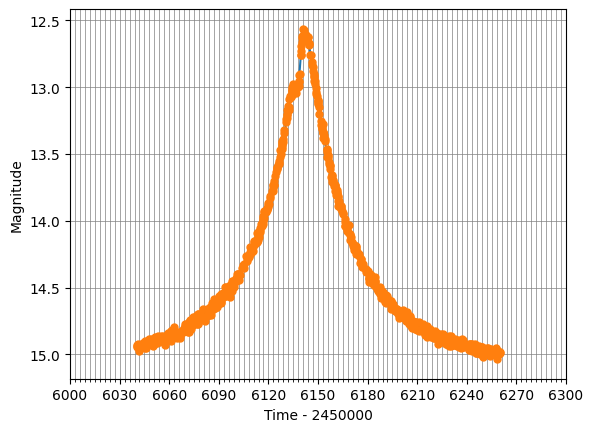

241.8181818181818
Successfully updated parameters. New config saved to /content/example_18_KMTNet.yaml
chi^2: 791.10


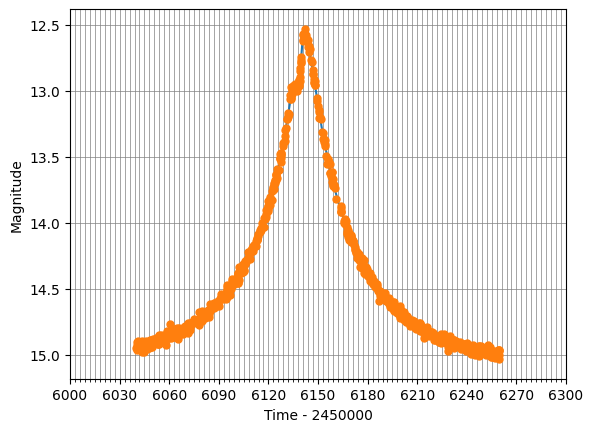

243.63636363636363
Successfully updated parameters. New config saved to /content/example_18_KMTNet.yaml
chi^2: 850.56


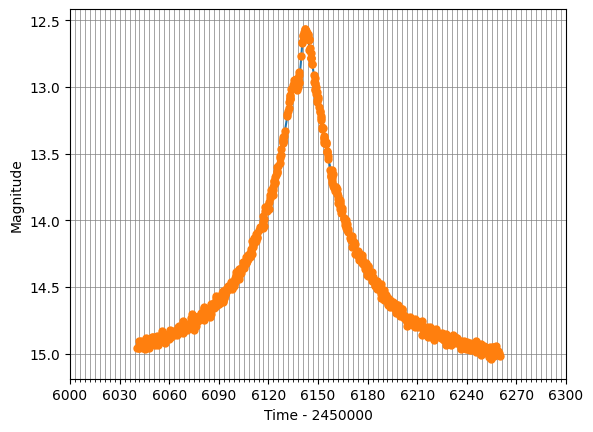

245.45454545454544
Successfully updated parameters. New config saved to /content/example_18_KMTNet.yaml
chi^2: 731.88


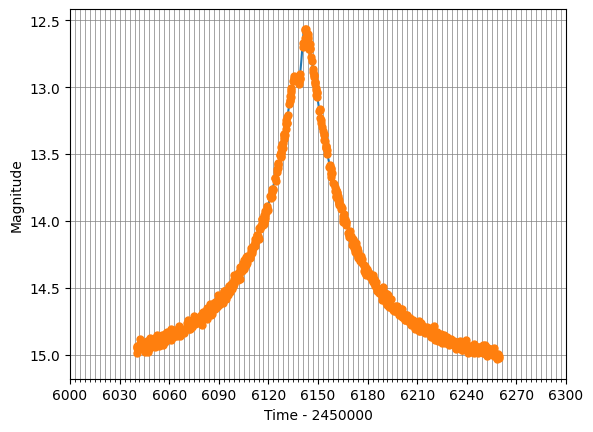

247.27272727272725
Successfully updated parameters. New config saved to /content/example_18_KMTNet.yaml
chi^2: 777.75


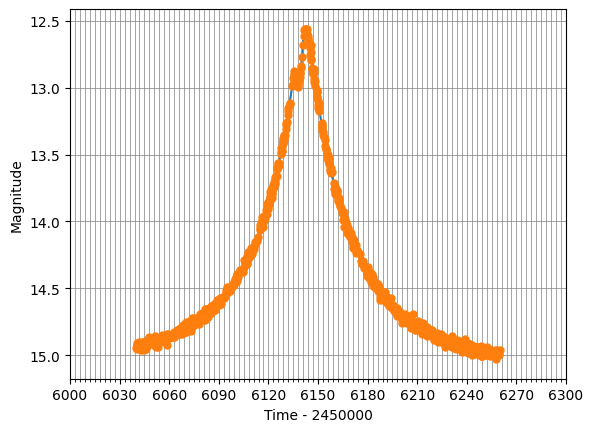

249.0909090909091
Successfully updated parameters. New config saved to /content/example_18_KMTNet.yaml
chi^2: 766.61


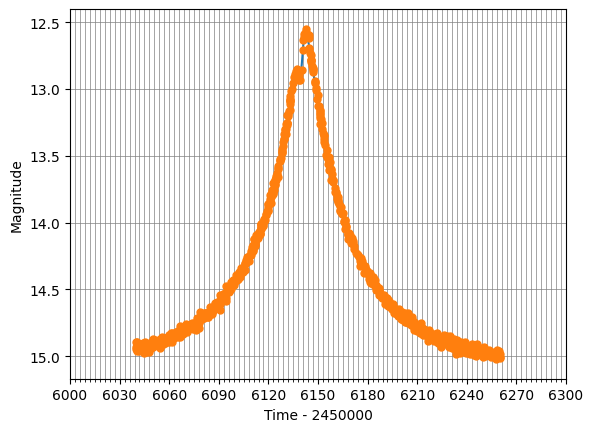

250.9090909090909
Successfully updated parameters. New config saved to /content/example_18_KMTNet.yaml
chi^2: 917.38


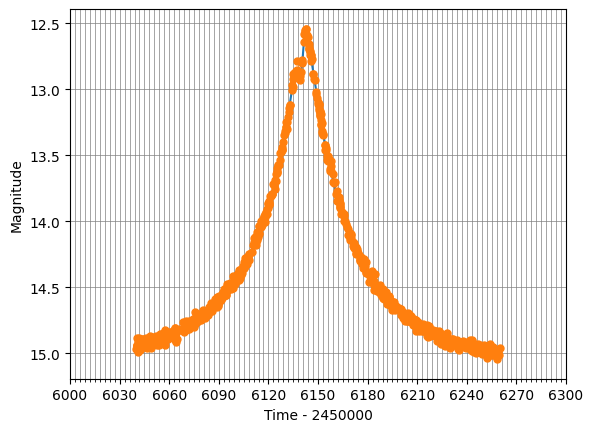

252.72727272727272
Successfully updated parameters. New config saved to /content/example_18_KMTNet.yaml
chi^2: 784.12


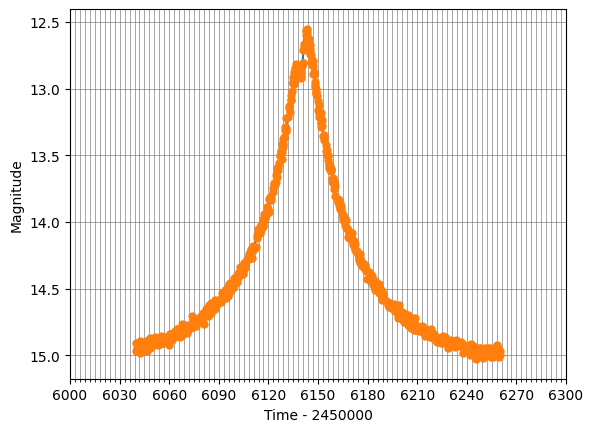

254.54545454545456
Successfully updated parameters. New config saved to /content/example_18_KMTNet.yaml
chi^2: 820.07


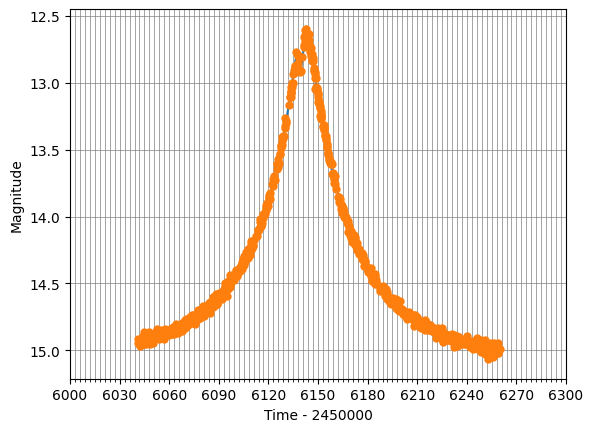

256.3636363636364
Successfully updated parameters. New config saved to /content/example_18_KMTNet.yaml
chi^2: 835.82


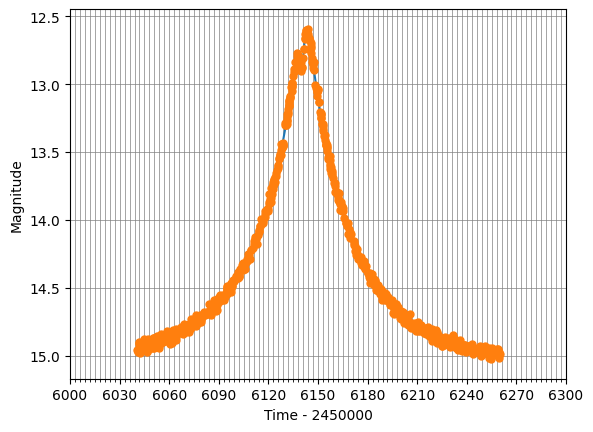

258.1818181818182
Successfully updated parameters. New config saved to /content/example_18_KMTNet.yaml
chi^2: 812.27


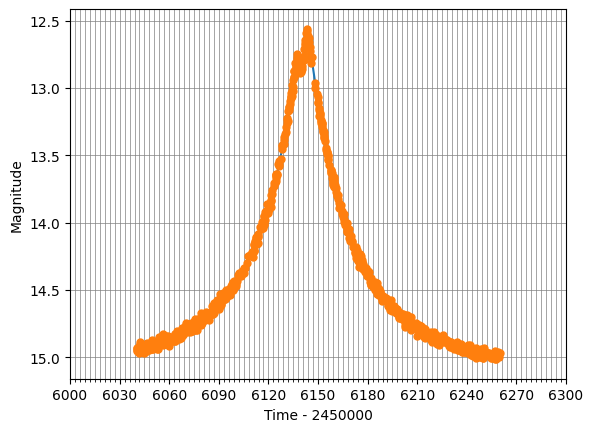

260.0
Successfully updated parameters. New config saved to /content/example_18_KMTNet.yaml
chi^2: 762.14


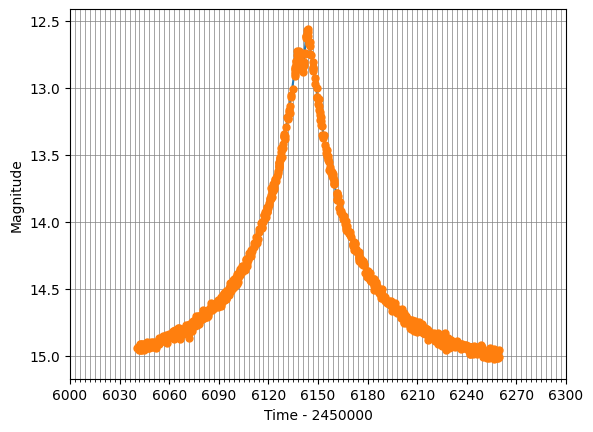

261.8181818181818
Successfully updated parameters. New config saved to /content/example_18_KMTNet.yaml
chi^2: 812.26


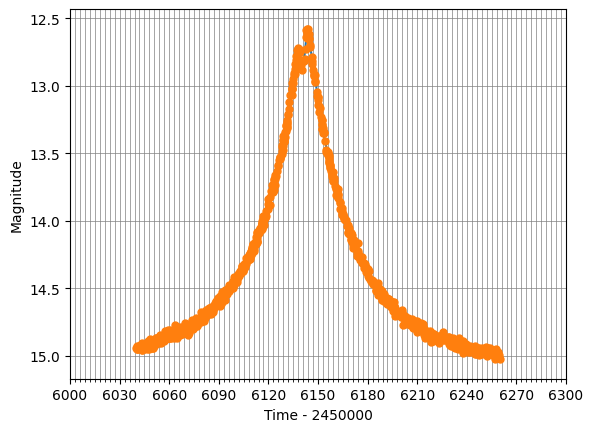

263.6363636363636
Successfully updated parameters. New config saved to /content/example_18_KMTNet.yaml
chi^2: 787.40


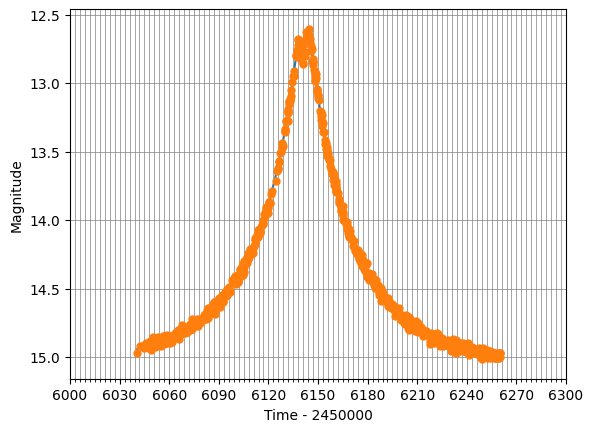

265.45454545454544
Successfully updated parameters. New config saved to /content/example_18_KMTNet.yaml
chi^2: 792.44


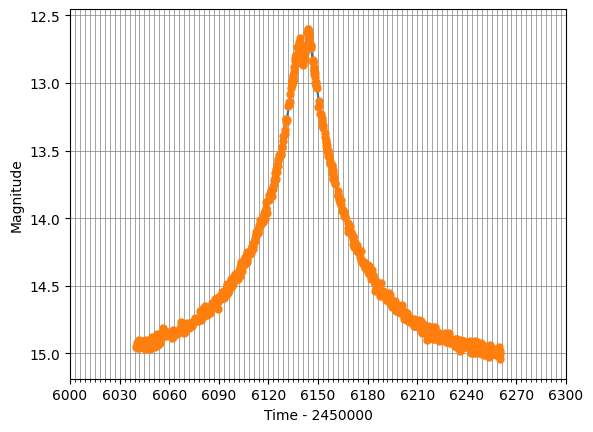

267.27272727272725
Successfully updated parameters. New config saved to /content/example_18_KMTNet.yaml
chi^2: 750.15


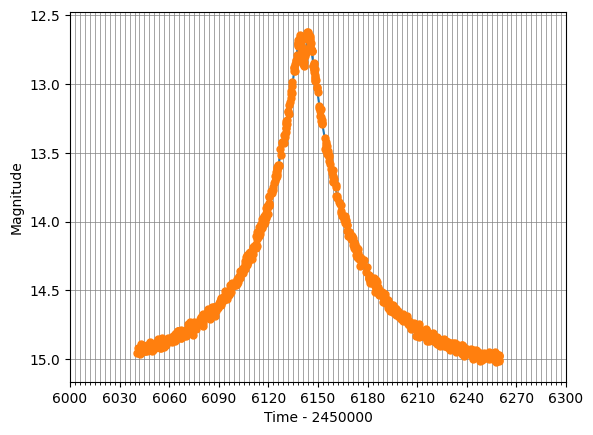

269.0909090909091
Successfully updated parameters. New config saved to /content/example_18_KMTNet.yaml
chi^2: 802.15


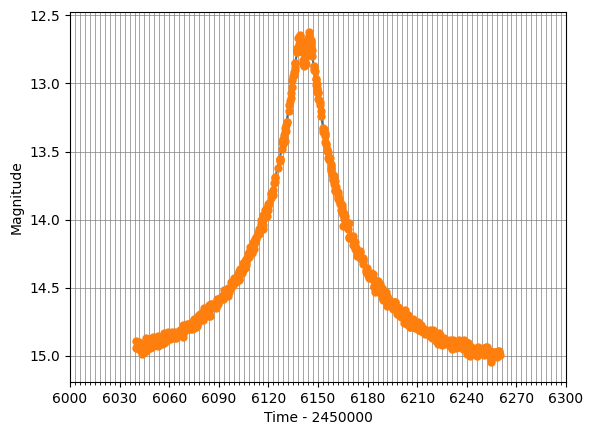

270.9090909090909
Successfully updated parameters. New config saved to /content/example_18_KMTNet.yaml
chi^2: 807.35


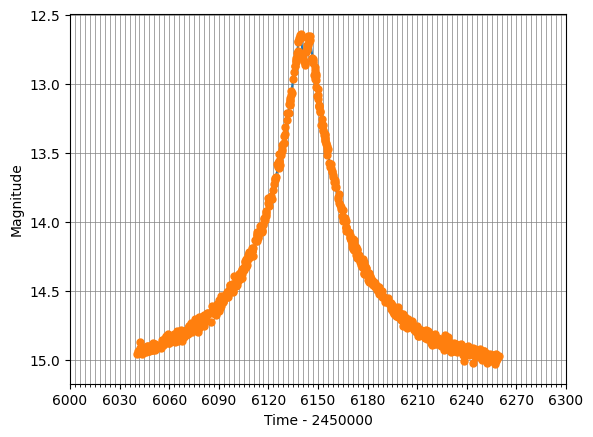

272.72727272727275
Successfully updated parameters. New config saved to /content/example_18_KMTNet.yaml
chi^2: 841.73


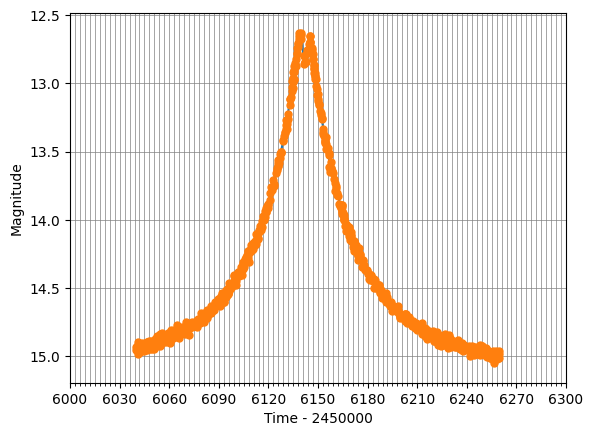

274.54545454545456
Successfully updated parameters. New config saved to /content/example_18_KMTNet.yaml
chi^2: 898.12


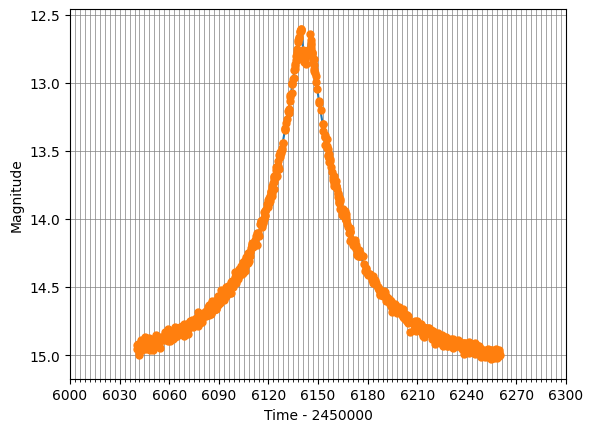

276.3636363636364
Successfully updated parameters. New config saved to /content/example_18_KMTNet.yaml
chi^2: 799.82


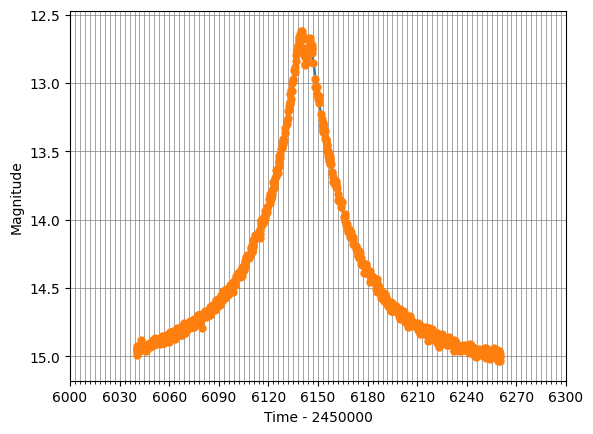

278.1818181818182
Successfully updated parameters. New config saved to /content/example_18_KMTNet.yaml
chi^2: 807.28


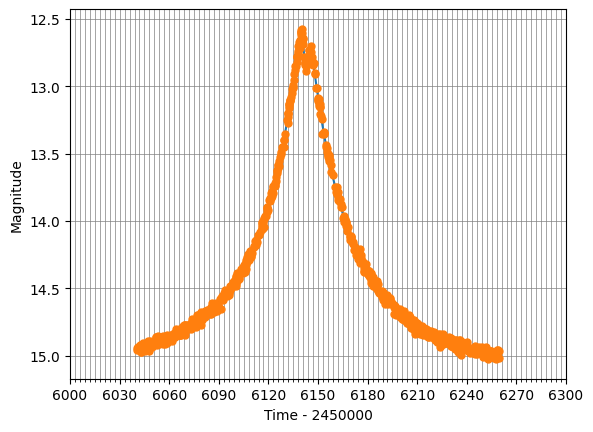

280.0
Successfully updated parameters. New config saved to /content/example_18_KMTNet.yaml
chi^2: 765.24


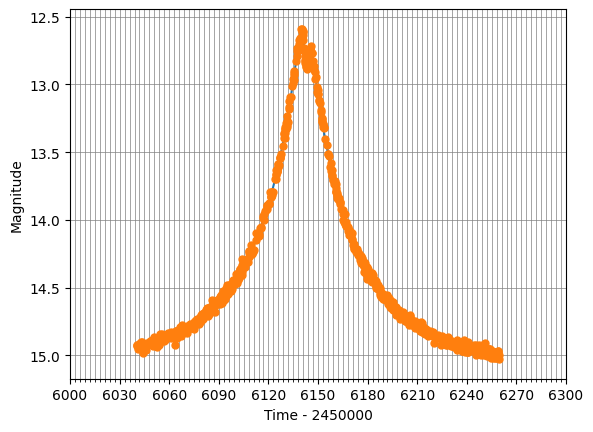

281.8181818181818
Successfully updated parameters. New config saved to /content/example_18_KMTNet.yaml
chi^2: 845.77


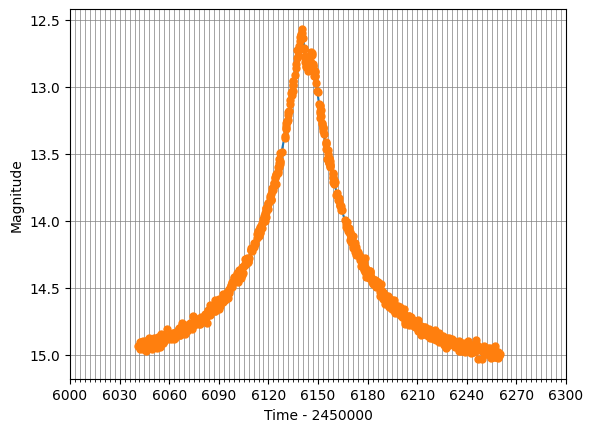

283.6363636363636
Successfully updated parameters. New config saved to /content/example_18_KMTNet.yaml
chi^2: 878.99


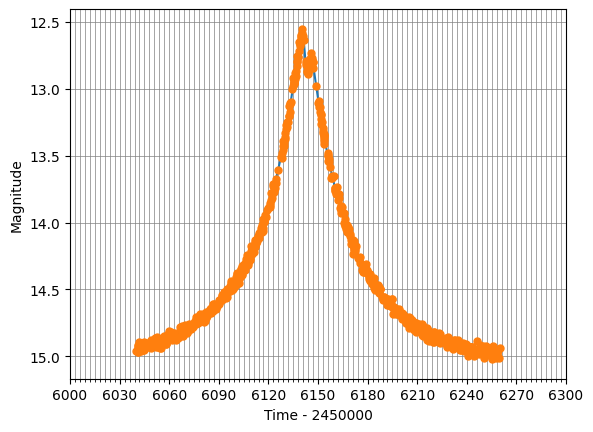

285.45454545454544
Successfully updated parameters. New config saved to /content/example_18_KMTNet.yaml
chi^2: 812.23


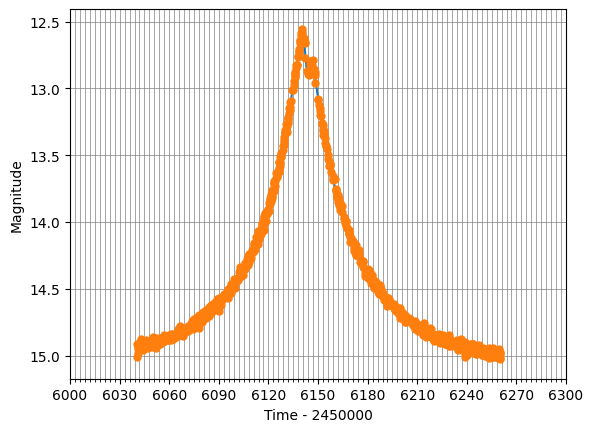

287.27272727272725
Successfully updated parameters. New config saved to /content/example_18_KMTNet.yaml
chi^2: 771.06


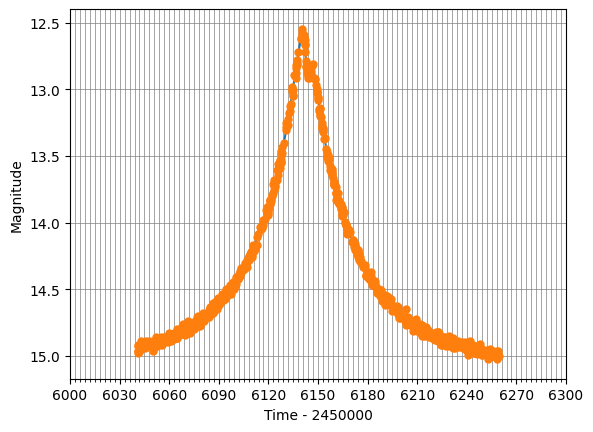

289.0909090909091
Successfully updated parameters. New config saved to /content/example_18_KMTNet.yaml
chi^2: 737.19


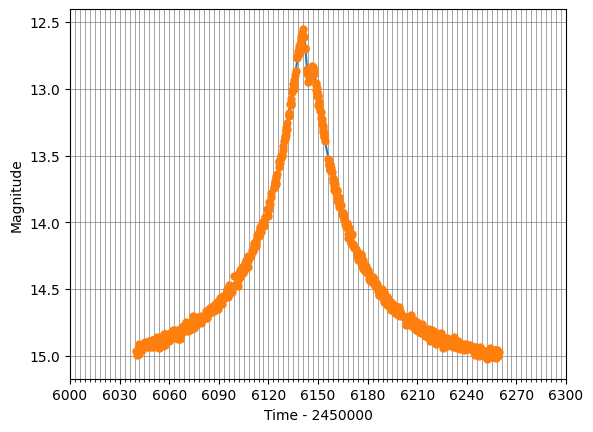

290.9090909090909
Successfully updated parameters. New config saved to /content/example_18_KMTNet.yaml
chi^2: 825.80


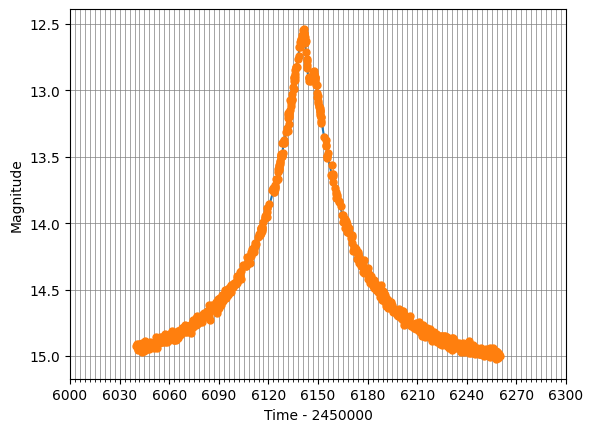

292.72727272727275
Successfully updated parameters. New config saved to /content/example_18_KMTNet.yaml
chi^2: 779.32


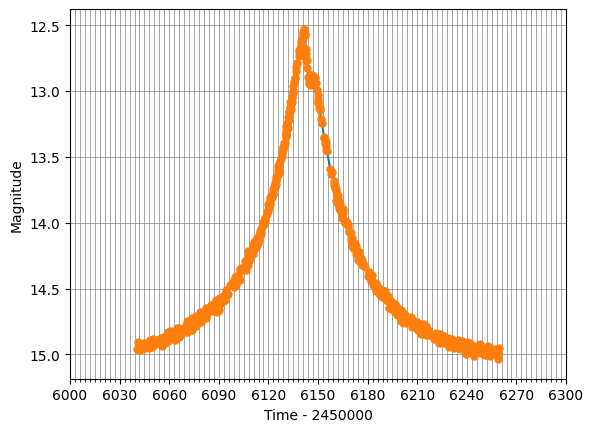

294.54545454545456
Successfully updated parameters. New config saved to /content/example_18_KMTNet.yaml
chi^2: 796.50


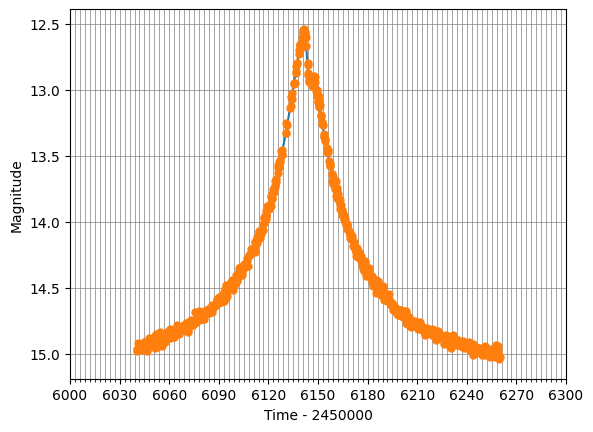

296.3636363636364
Successfully updated parameters. New config saved to /content/example_18_KMTNet.yaml
chi^2: 758.56


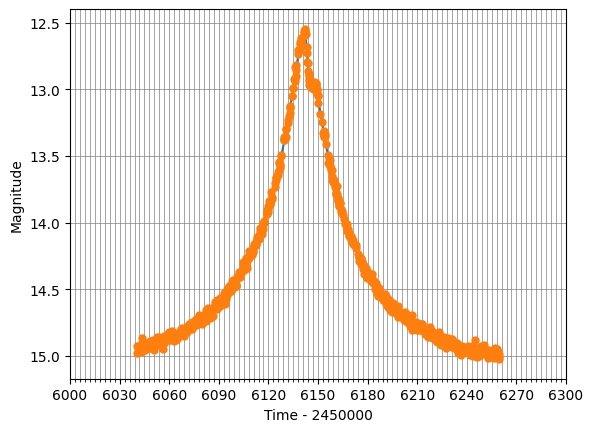

298.1818181818182
Successfully updated parameters. New config saved to /content/example_18_KMTNet.yaml
chi^2: 726.50


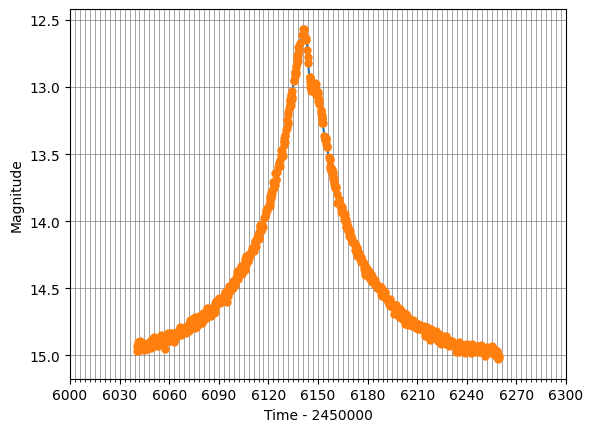

300.0
Successfully updated parameters. New config saved to /content/example_18_KMTNet.yaml
chi^2: 761.65


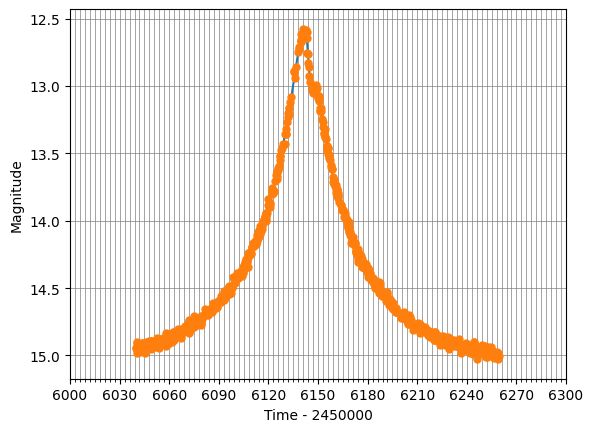

301.8181818181818
Successfully updated parameters. New config saved to /content/example_18_KMTNet.yaml
chi^2: 798.31


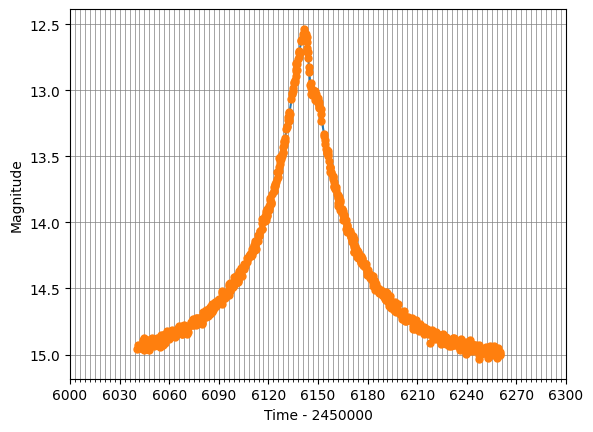

303.6363636363636
Successfully updated parameters. New config saved to /content/example_18_KMTNet.yaml
chi^2: 786.27


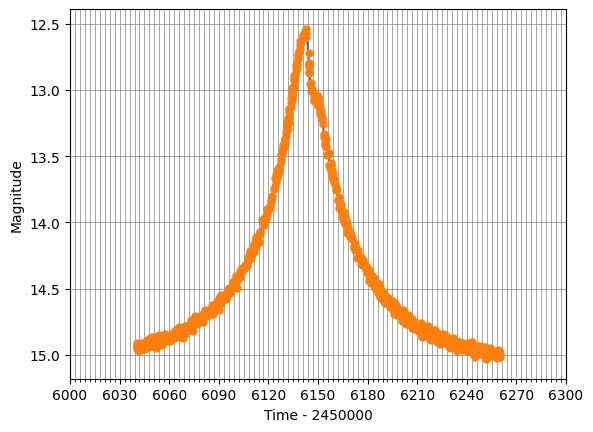

305.45454545454544
Successfully updated parameters. New config saved to /content/example_18_KMTNet.yaml
chi^2: 817.32


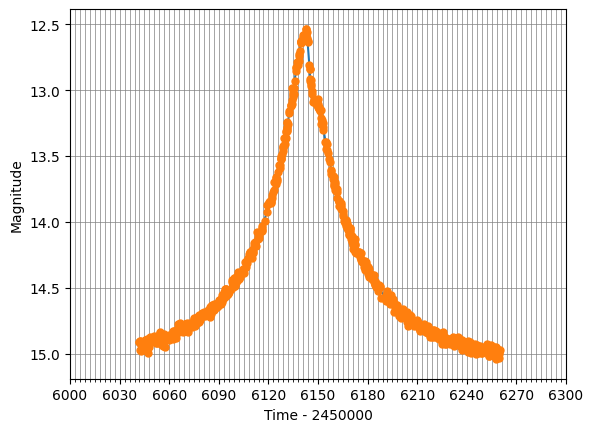

307.27272727272725
Successfully updated parameters. New config saved to /content/example_18_KMTNet.yaml
chi^2: 785.87


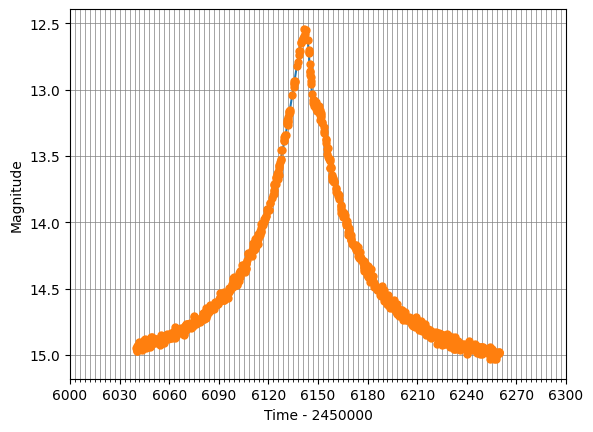

309.0909090909091
Successfully updated parameters. New config saved to /content/example_18_KMTNet.yaml
chi^2: 870.25


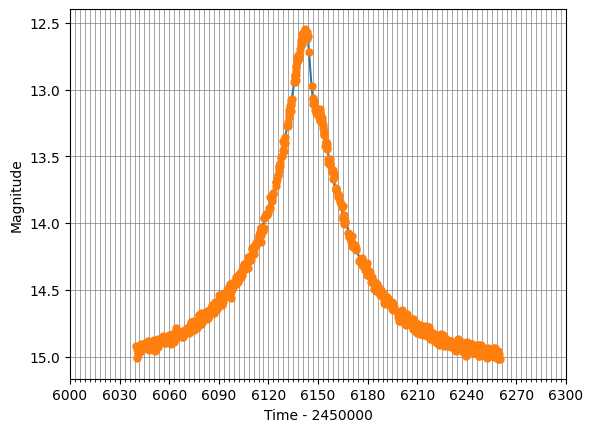

310.9090909090909
Successfully updated parameters. New config saved to /content/example_18_KMTNet.yaml
chi^2: 811.80


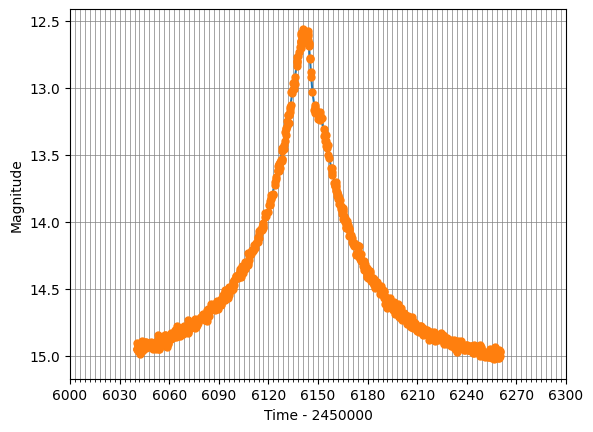

312.72727272727275
Successfully updated parameters. New config saved to /content/example_18_KMTNet.yaml
chi^2: 805.31


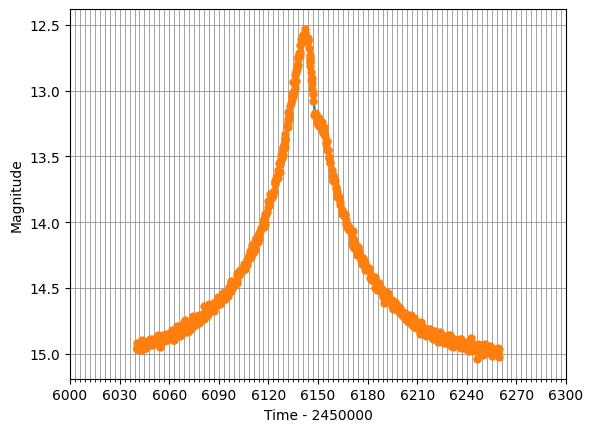

314.5454545454545
Successfully updated parameters. New config saved to /content/example_18_KMTNet.yaml
chi^2: 850.34


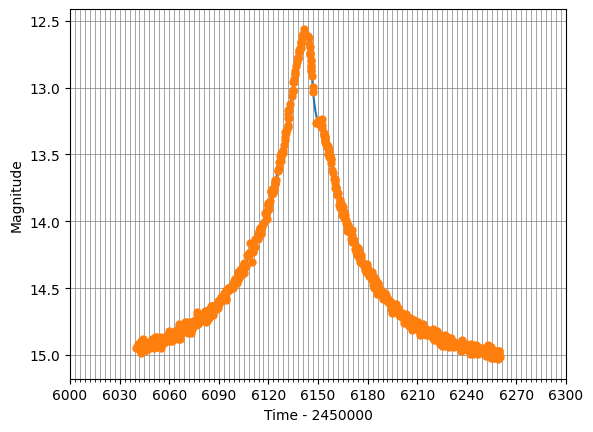

316.3636363636364
Successfully updated parameters. New config saved to /content/example_18_KMTNet.yaml
chi^2: 762.20


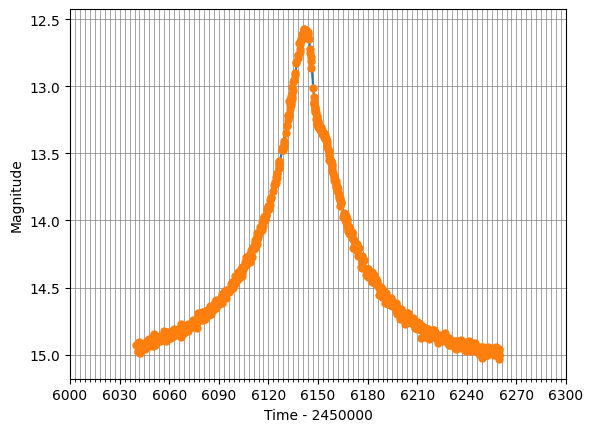

318.1818181818182
Successfully updated parameters. New config saved to /content/example_18_KMTNet.yaml
chi^2: 855.17


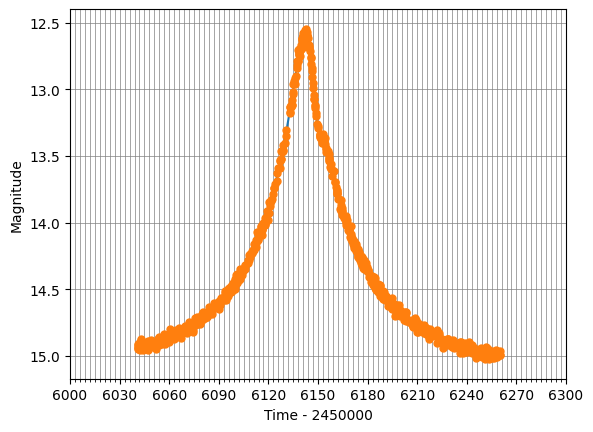

320.0
Successfully updated parameters. New config saved to /content/example_18_KMTNet.yaml
chi^2: 810.70


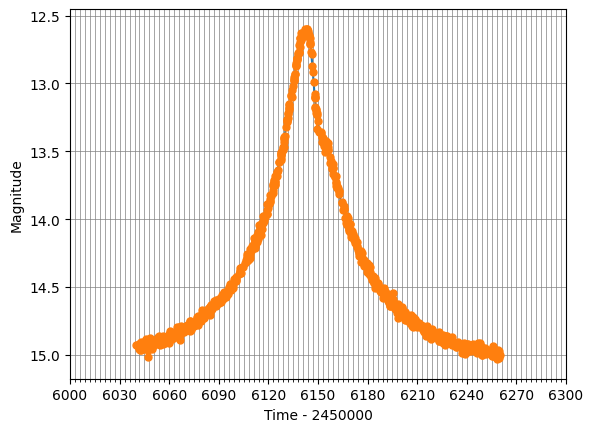

321.8181818181818
Successfully updated parameters. New config saved to /content/example_18_KMTNet.yaml
chi^2: 852.43


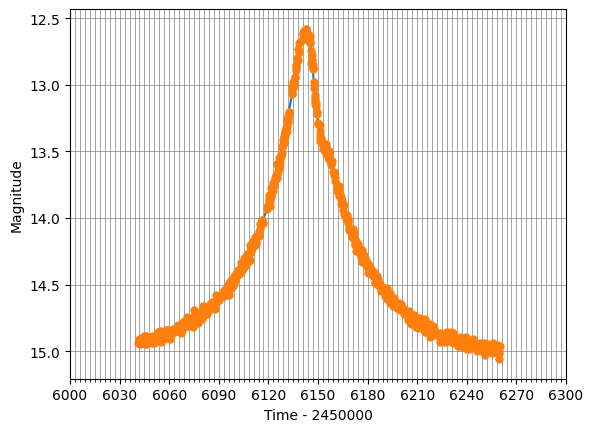

323.6363636363636
Successfully updated parameters. New config saved to /content/example_18_KMTNet.yaml
chi^2: 862.29


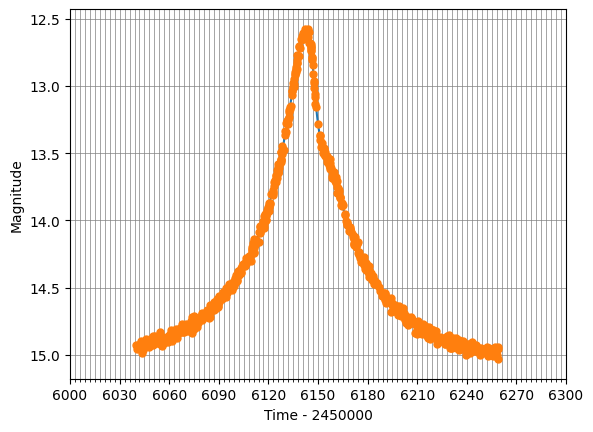

325.45454545454544
Successfully updated parameters. New config saved to /content/example_18_KMTNet.yaml
chi^2: 795.98


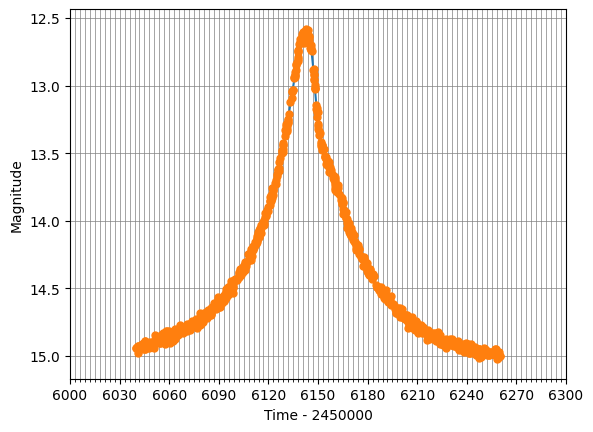

327.27272727272725
Successfully updated parameters. New config saved to /content/example_18_KMTNet.yaml
chi^2: 840.11


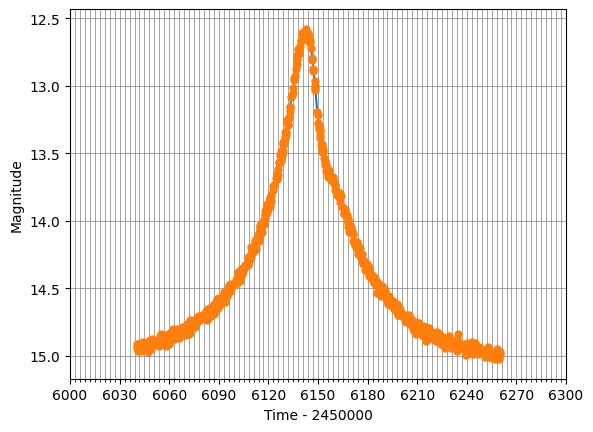

329.0909090909091
Successfully updated parameters. New config saved to /content/example_18_KMTNet.yaml
chi^2: 751.29


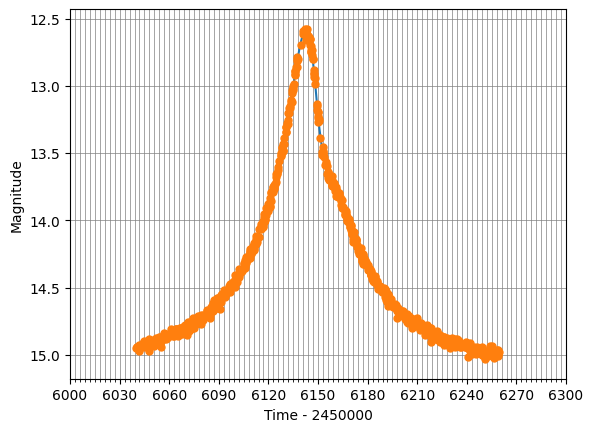

330.9090909090909
Successfully updated parameters. New config saved to /content/example_18_KMTNet.yaml
chi^2: 760.74


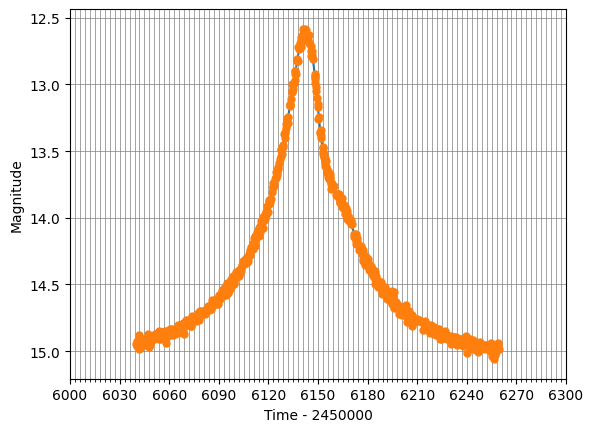

332.72727272727275
Successfully updated parameters. New config saved to /content/example_18_KMTNet.yaml
chi^2: 727.45


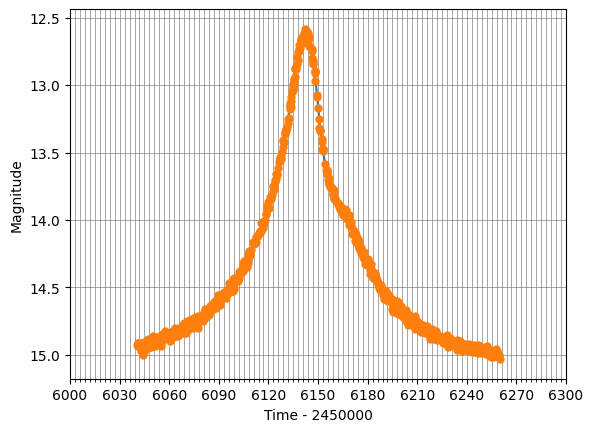

334.5454545454545
Successfully updated parameters. New config saved to /content/example_18_KMTNet.yaml
chi^2: 706.10


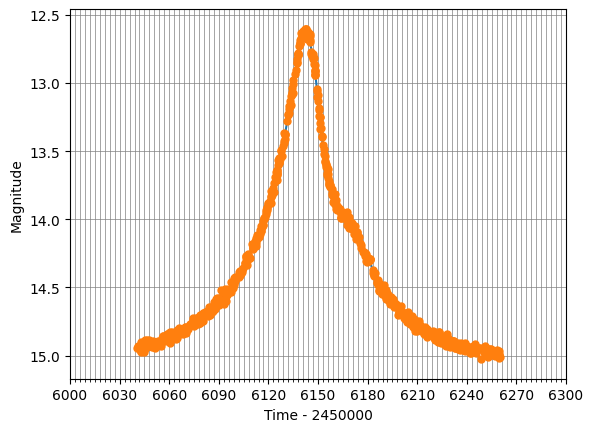

336.3636363636364
Successfully updated parameters. New config saved to /content/example_18_KMTNet.yaml
chi^2: 806.74


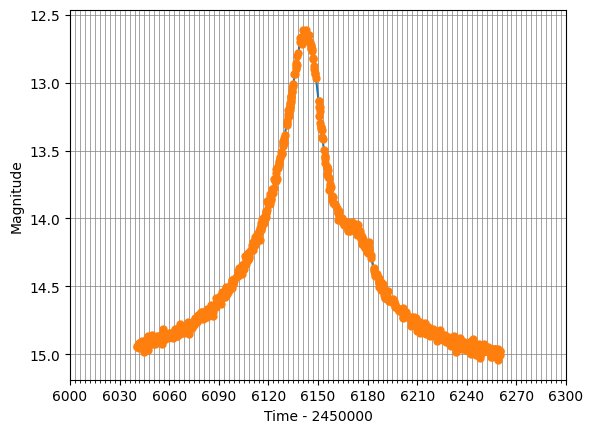

338.1818181818182
Successfully updated parameters. New config saved to /content/example_18_KMTNet.yaml
chi^2: 848.23


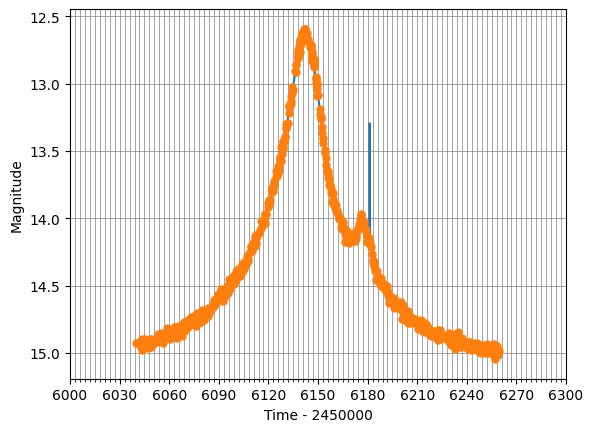

340.0
Successfully updated parameters. New config saved to /content/example_18_KMTNet.yaml
chi^2: 763.62


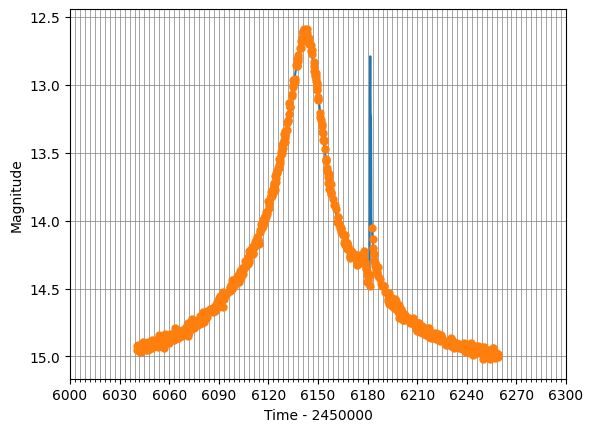

341.8181818181818
Successfully updated parameters. New config saved to /content/example_18_KMTNet.yaml
chi^2: 860.17


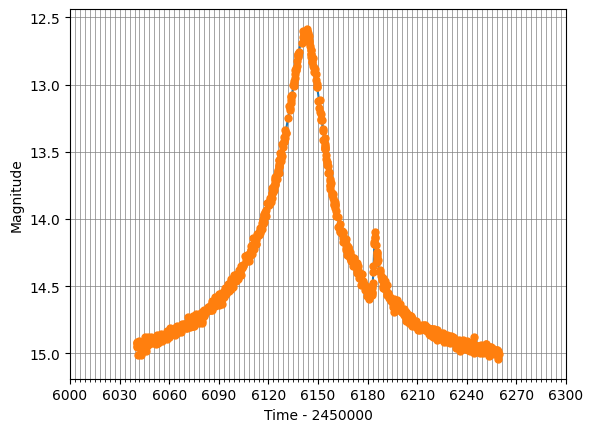

343.6363636363636
Successfully updated parameters. New config saved to /content/example_18_KMTNet.yaml
chi^2: 796.66


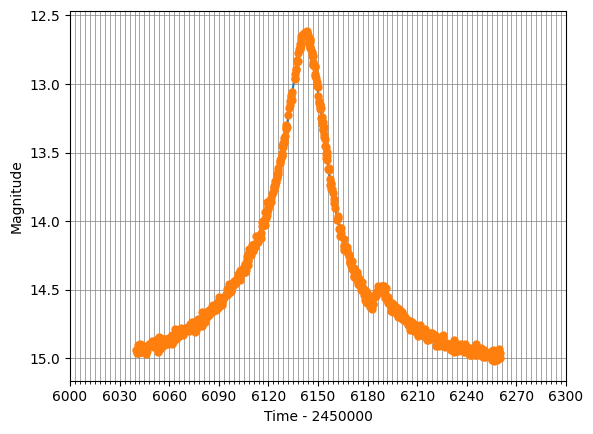

345.45454545454544
Successfully updated parameters. New config saved to /content/example_18_KMTNet.yaml
chi^2: 822.70


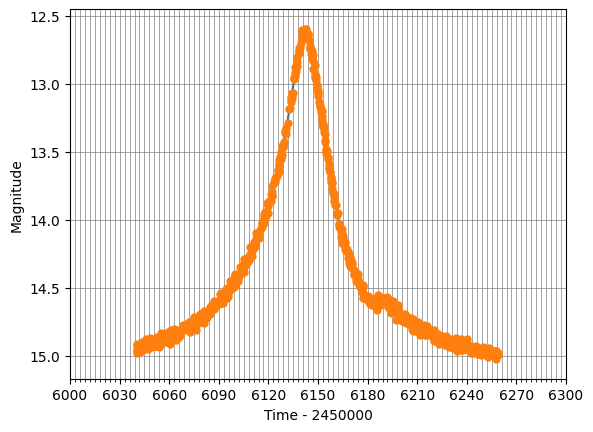

347.27272727272725
Successfully updated parameters. New config saved to /content/example_18_KMTNet.yaml
chi^2: 818.86


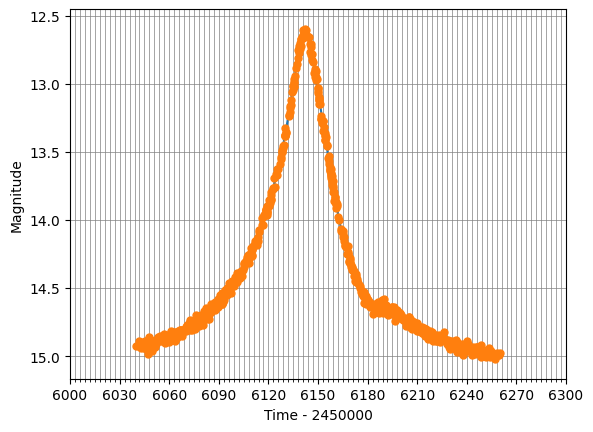

349.0909090909091
Successfully updated parameters. New config saved to /content/example_18_KMTNet.yaml
chi^2: 738.55


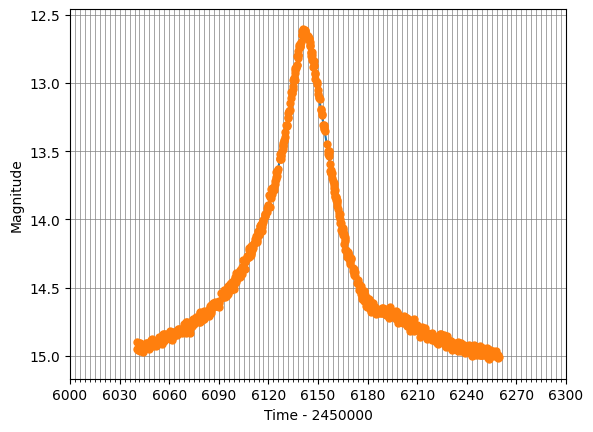

350.9090909090909
Successfully updated parameters. New config saved to /content/example_18_KMTNet.yaml
chi^2: 765.45


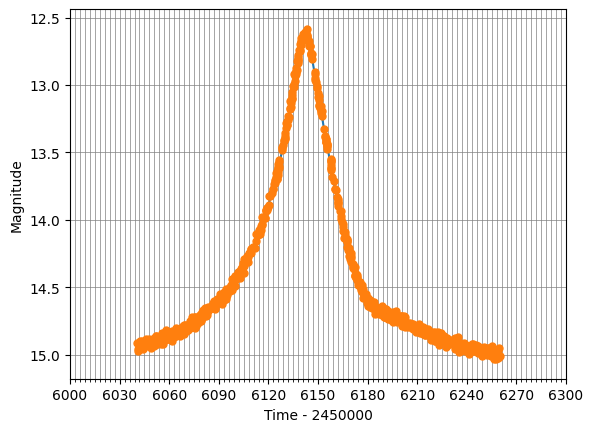

352.72727272727275
Successfully updated parameters. New config saved to /content/example_18_KMTNet.yaml
chi^2: 799.68


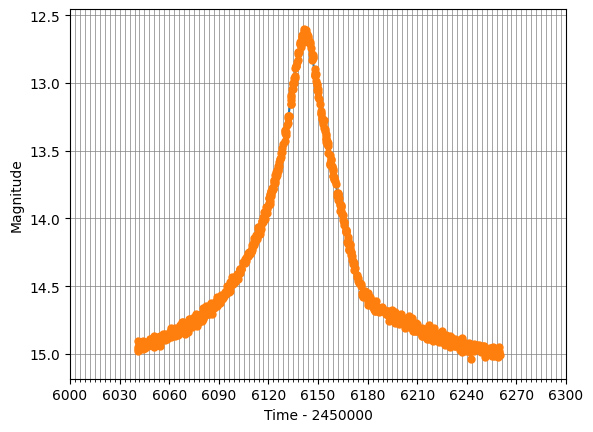

354.5454545454545
Successfully updated parameters. New config saved to /content/example_18_KMTNet.yaml
chi^2: 808.74


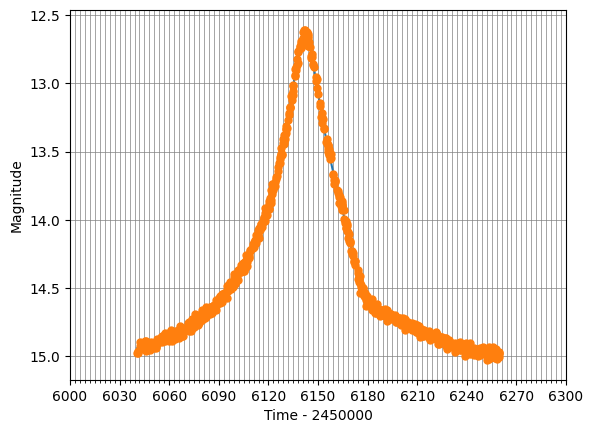

356.3636363636364
Successfully updated parameters. New config saved to /content/example_18_KMTNet.yaml
chi^2: 819.75


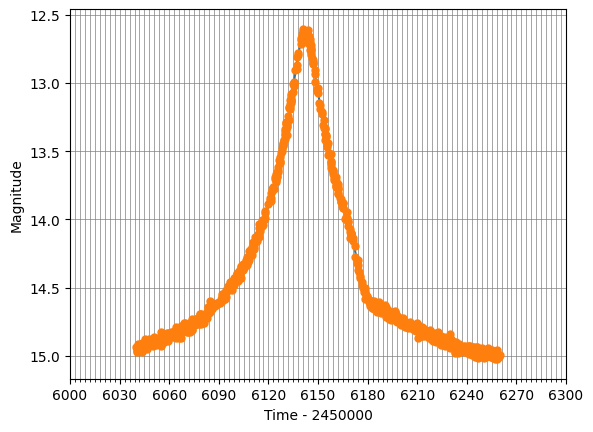

358.1818181818182
Successfully updated parameters. New config saved to /content/example_18_KMTNet.yaml
chi^2: 841.49


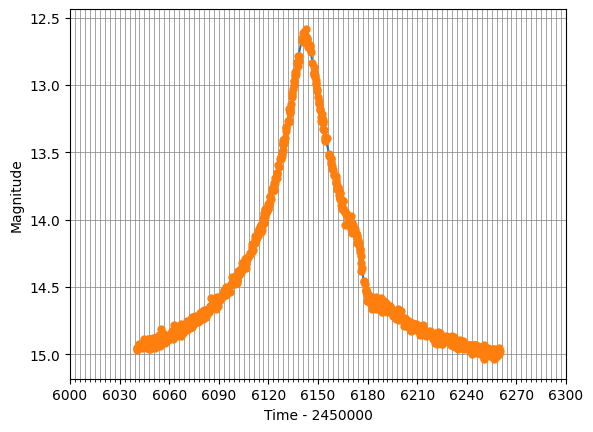

360.0
Successfully updated parameters. New config saved to /content/example_18_KMTNet.yaml
chi^2: 784.38


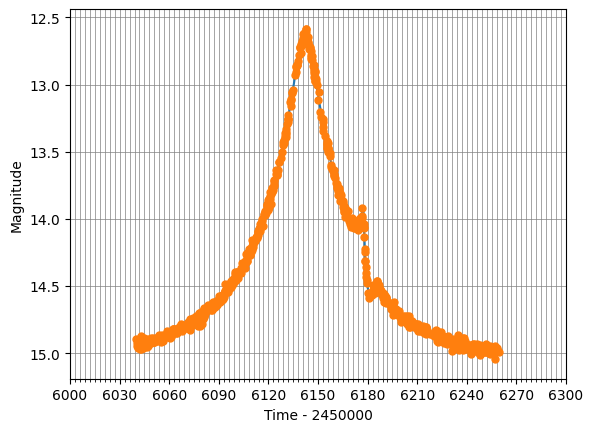

In [6]:
q = 0.004
tE = 68.25
s = 0.75
u0 = 0.8
alpha = np.linspace(180, 360, 100)

if __name__ == '__main__':
  for a in alpha:
    print(a)
    vary_yaml_parameters('/content/example_18_KMTNet.yaml', '/content/example_18_KMTNet.yaml', s, q, a, u0, tE)
    input_file = '/content/example_18_KMTNet.yaml'
    with open(input_file, 'r') as in_file:
        settings = yaml.safe_load(in_file)

    simulate_lc(**settings)
